In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import sys

sys.path.append("../")
from models import utils

torch.set_grad_enabled(False)
torch.set_num_threads(4)

## Load model

In [5]:
### Load the model
# noise level used at training
sigma = 5
# number of gradient steps used at training
t = 10
device = 'cuda:1'
exp_name = f'BioMed/Sigma_{sigma}_t_{t}'
exp_name = 'Sigma_25_t_10'
model = utils.load_model(exp_name, device=device)
model.eval()

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------


ConvexRidgeRegularizer(
  (conv_layer): MultiConv2d(
    (conv_layers): ModuleList(
      (0): ParametrizedConv2d(
        1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): ZeroMean()
          )
        )
      )
      (1): ParametrizedConv2d(
        8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): ZeroMean()
          )
        )
      )
    )
  )
  (activation): LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.)
)

# Plot filters and activations

Activations

In [6]:
# draw the activations
nch = model.activation.num_activations
# input
x = torch.linspace(-1.1 * model.activation.grid.item() * model.activation.size/2, 1.1 * model.activation.grid.item() * model.activation.size/2, 1000).to(device).view(1,1,1,-1).tile((1,nch,1,1))
# output
y = model.activation(x)

Filters impulse response

/tmp/ipykernel_3024244/2321115010.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


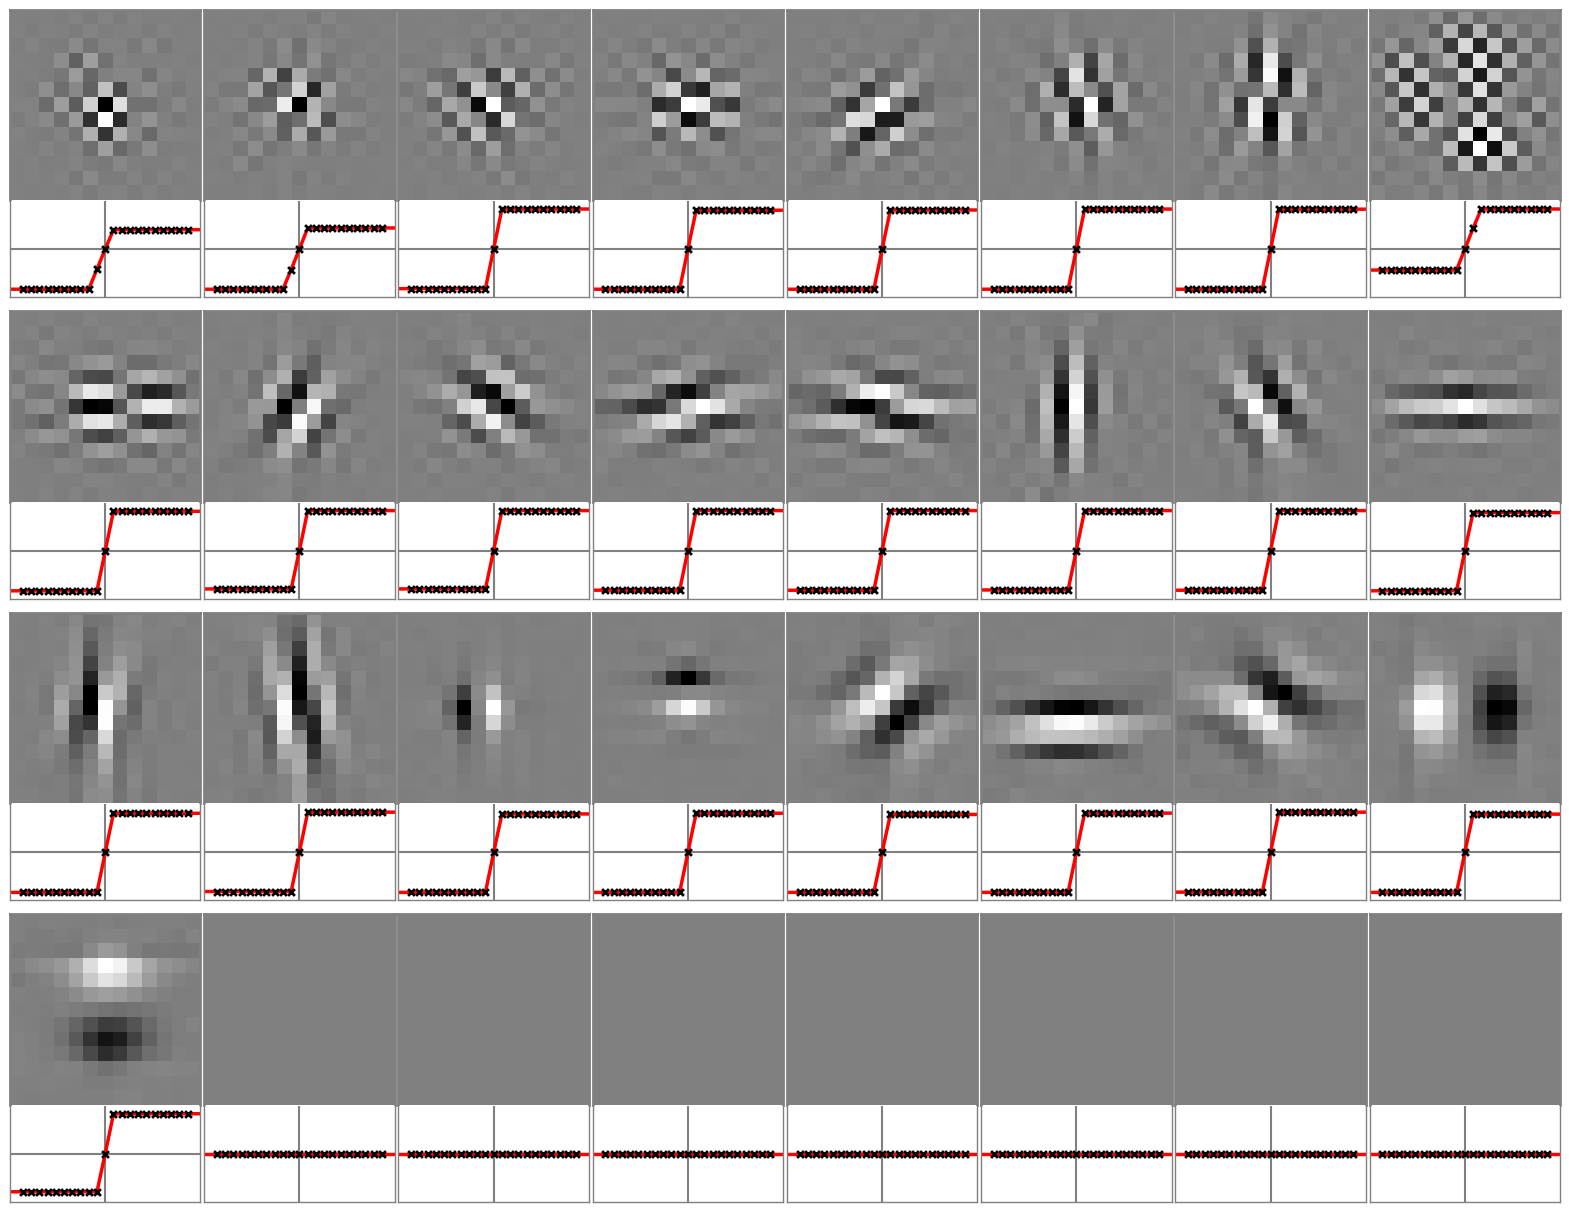

In [8]:
# size of equivalent kernel
n = 2 * sum(conv.kernel_size[0]//2 for conv in model.conv_layer.conv_layers) + 1
# dirac
dirac = torch.zeros((1,1,n,n),device=device, requires_grad=False)
dirac[0,0,n//2,n//2] = 1
# impulse response
kernel = model.conv_layer.convolution(dirac)

# weight of the channels, related to kernel weight and spline tv2
coeff = model.activation.monotonic_coefficients.to("cpu")
slopes = (coeff[:,1:] - coeff[:,:-1])/model.activation.grid
tv2 = torch.sum(torch.abs(slopes), dim=1)

kernel_weight = torch.sum(kernel.abs(), dim=(0,2,3))
ord_ = torch.sort(kernel_weight.cpu()*tv2, descending=False)[1]

L = np.array([15, 28, 15, 18])
N = int(math.sqrt(kernel.shape[1]))+1
u = np.zeros(((kernel.shape[1]//N +1)*n, N*n))

n1 = 8
widths = [3 for i in range(8)]
heights = []
nrows = 4
for i in range(nrows):
    heights.append(3)
    heights.append(1.5)
    heights.append(0.2)
        

W = sum(widths)
H = sum(heights)
wd = 20
fig5 = plt.figure(figsize=(wd, wd*H/W))

spec5 = fig5.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                          height_ratios=heights, wspace=0.02, hspace=0.0)
                          
# for k,i in enumerate(reversed(ord_)):

for k,i in enumerate(reversed(ord_)):
    weight = math.sqrt(tv2[i].item())

    n1 = (k//8)
    n2 = (k - 8*(k//8))

    if n1 < nrows:
        ax1 = fig5.add_subplot(spec5[3*n1, n2])
        im = weight*(kernel[0,i]).detach().cpu().numpy()
        amplitude = max((np.abs(im).max()), 1e-7)
        ax1.imshow(im, cmap="gray", interpolation=None, vmin=-amplitude, vmax=amplitude)

        ax1.set_xticks([])
        ax1.set_yticks([])

        ax2 = fig5.add_subplot(spec5[3*n1 + 1, n2])
        xl = x.detach().cpu().squeeze()[0]
        ax2.plot(x.detach().cpu().squeeze()[0],xl*0,color='gray')
        yl = y[0,i,0,:].cpu()
        
        
        
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
        amplitude = 1.2*max(yl.abs().max().item(),1e-8)
        ax2.plot([0,0],[-amplitude, amplitude],color='gray')
        
        ax2.plot(x.detach().cpu().squeeze()[0], yl, color='red', lw=2.5)

        hk = model.activation.grid_tensor[i,:].cpu().numpy()
        ck = model.activation.projected_coefficients[i,:].cpu().numpy()
        ax2.scatter(hk, ck, marker='x', color='k', s=24, linewidths=2, zorder=3)


        ax2.set_ylim(-amplitude, amplitude)
        ax2.set_xlim(xl.min(), xl.max())
        ax2.set_xticks([])
        ax2.set_yticks([])

        ax1.spines['bottom'].set_visible(False)
        ax1.tick_params(color='green')


        ax2.spines['top'].set_visible(False)
        color = "gray"
        color2 = "gray"
        lw1 = 2
        lw2 = 1
        for pos in ['top', 'bottom', 'right', 'left']:
            ax1.spines[pos].set_edgecolor(color)
            ax2.spines[pos].set_edgecolor(color2)
            ax1.spines[pos].set_linewidth(lw1)
            ax2.spines[pos].set_linewidth(lw2)


plt.tight_layout()
# plt.savefig("bin/activations_filters_MRI_25_.pdf", bbox_inches='tight', pad_inches=0)